# 🐱 고양이 수염 스티커 만들기

오늘은 본인의 사진에 고양이 스티커를 붙혀볼까 한다.

## Step 1. 스티커 구하기

고양이 스티커 png 파일은  flaticon 사이트에 무료로 공개된 파일을 사용했다.
<https://www.flaticon.com/free-icon/cat-whiskers_24674?term=cat%20nose&page=1&position=1>

## Step 2. 얼굴 검출 & 랜드마크 검출 하기

### 2-1 사진 준비하기

필요한 라이브러리를 import 한다.

In [477]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

사진을 불러온후, 나중에 필요한 사진들을 복사 해놓는다.

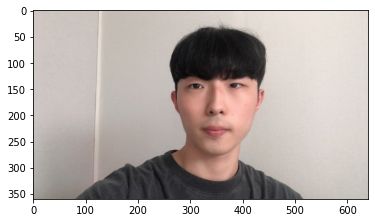

In [536]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (640, 360))

img_show = img_bgr.copy()
img_bgr2 = img_bgr.copy()
img_addwei = img_bgr.copy()


img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

openCV는 이미지 채녈을 BGR 순으로 사용하기에 RGB 채널의 순서로 변환한다.

### 2-2 얼굴 검출하기

Hog Detector를 선언하고 위에서 불러온 이미지를 입력한다.

In [537]:
import dlib
detector_hog = dlib.get_frontal_face_detector() 
dlib_rects = detector_hog(img_rgb, 1) 

rectangles[[(270, 116) (425, 270)]]


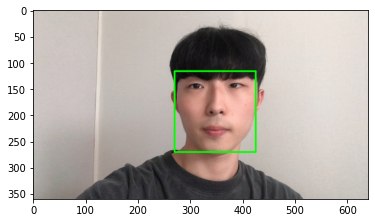

In [538]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

얼굴 ROI가 잘 잡힌걸 확인할 수 있다.

### 2-3 얼굴 랜드마크 검출하기

이번 프로젝트에서 사용할 알고리즘은 Object keypoint estimation이다.
ROI에서 68개의 이목구비 위치를 찾는다.

In [539]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [540]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


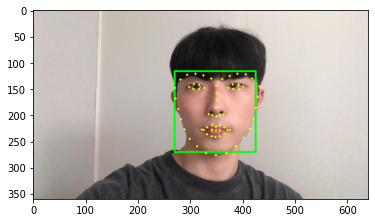

In [541]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Step 3. 스티커 적용 위치 확인하기

1. 스티커의 위치와 크기좌표를 구한다.
- 볼의 위치를 찾기위해 2,30,36,48 네 가지의 랜드마크를 잇는 직선의 교점을 구했다.
- 스티커의 크기는 두 볼의 x좌표를 뺀 값으로 가로, 세로 같은 비율로 정했다.

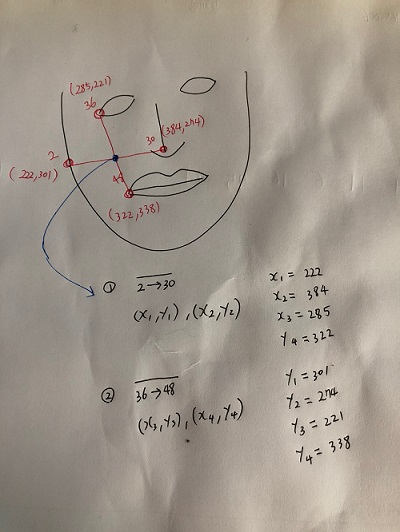

(x,y) : (384,162)
(w,h) : (78,78)


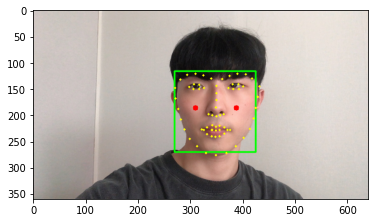

In [542]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    
    x1 = landmark[2][0]; y1 = landmark[2][1]
    x2 = landmark[30][0]; y2 = landmark[30][1]
    x3 = landmark[36][0]; y3 = landmark[36][1]
    x4 = landmark[48][0]; y4 = landmark[48][1]
    
    x5 = landmark[14][0]; y5 = landmark[2][1]
    x6 = landmark[30][0]; y6 = landmark[30][1]
    x7 = landmark[45][0]; y7 = landmark[36][1]
    x8 = landmark[54][0]; y8 = landmark[48][1]
    
    
    #4좌표가 주어질때 교점 구하기 : https://gaussian37.github.io/math-algorithm-intersection_point/
    
    Px = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4))//((x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4))
    Py = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4))//((x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4))
    cv2.circle(img_show, (Px,Py), 5, (0, 0, 255), -1)
    
    
    Px2 = ((x5*y6 - y5*x6)*(x7 - x8) - (x5 - x6)*(x7*y8 - y7*x8))//((x5 - x6)*(y7 - y8) - (y5 - y6)*(x7 - x8))
    Py2 = ((x5*y6 - y5*x6)*(y7 - y8) - (y5 - y6)*(x7*y8 - y7*x8))//((x5 - x6)*(y7 - y8) - (y5 - y6)*(x7 - x8))
    cv2.circle(img_show, (Px2,Py2), 5, (0, 0, 255), -1)
    
    
    w = Px2 - Px
    h = Px2 - Px
    
    
    #w = dlib_rect.width()
    #h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    
    img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show)
    plt.show()

2. 스티커를 불러와서 위에서 정한 스티커의 크기만큼 resize 한다.

(78, 78, 3)


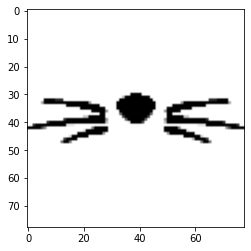

In [543]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))


print (img_sticker.shape)
plt.imshow(img_sticker); plt.show()

3. 이미지의 시작 좌표를 조정한다.

In [544]:
refined_x = Px # left
refined_y = Py - img_sticker.shape[0]//2  # top

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (310,147)


## Step 4. 스티커 적용하기

### 4-1 스티커 적용

우리가 사용할 고양이 수염 이미지는 배경이 흰색이기 때문에, np.where함수로 픽셀이 255값을 가지는 부분을 제외하고 사용한다.

In [545]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

sticker_area2 = img_addwei[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

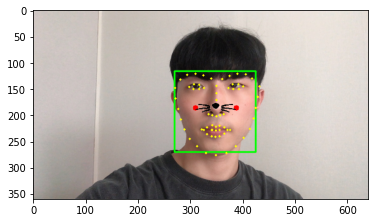

In [546]:
plt.imshow(img_show)

plt.show()

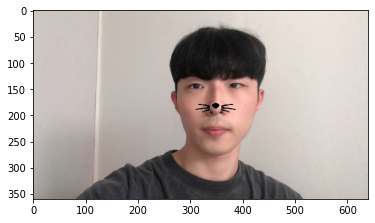

In [553]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 4-2 스티커를 자연스럽게 하기

자연스러운 스티커를 위해 새로운 이미지를 가져왔다.

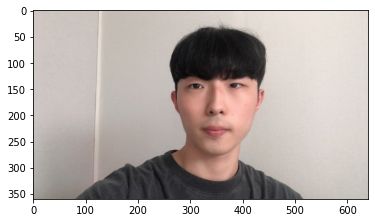

In [554]:
img_addwei = cv2.cvtColor(img_addwei, cv2.COLOR_BGR2RGB)
plt.imshow(img_addwei); plt.show()

opencv의 addweighted 함수는 사진에 가중치를 두어 블렌딩 해주는 함수이다.
가중치가 더 작을수록 희미한걸 볼 수 있다.

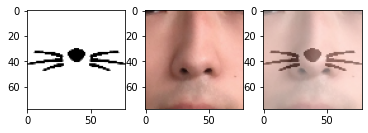

In [594]:
fig = plt.figure()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)


dst = cv2.addWeighted(sticker_area2, 0.6, img_sticker, 0.4, 0)

ax1.imshow(img_sticker)
ax2.imshow(sticker_area2)
ax3.imshow(dst)

plt.show()

np.where를 통해 스티커 이미지가 255인 부분은 원본사진을 대입하고 아닌 부분은 위에서 addweighted함수를 통해 만든 dst 이미지를 넣는다.

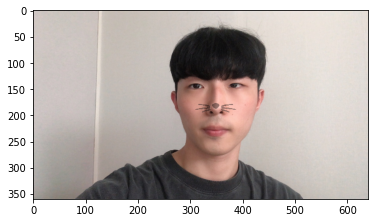

In [596]:
img_bgr2[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB))
plt.show()

## Step 5. 문제점 찾아보기

이번 코드에서 여러 문제점이 있겠지만 여러 경우의 사진을 가져왔다.      
사진을 가지고 위의 과정과 같이 스티커를 붙혀보았다.

In [45]:
import os
import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np

def make_sticker_img(img_path, sticker_path, img_w, img_h):
    img_bgr = cv2.imread(img_path)
    img_bgr = cv2.resize(img_bgr, (img_w, img_h))

    img_show = img_bgr.copy()
    img_bgr2 = img_bgr.copy()
    img_addwei = img_bgr.copy()


    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    detector_hog = dlib.get_frontal_face_detector() 
    dlib_rects = detector_hog(img_rgb, 1) 

    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    
    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)

    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    print(len(list_landmarks[0]))

    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):

        x1 = landmark[2][0]; y1 = landmark[2][1]
        x2 = landmark[30][0]; y2 = landmark[30][1]
        x3 = landmark[36][0]; y3 = landmark[36][1]
        x4 = landmark[48][0]; y4 = landmark[48][1]

        x5 = landmark[14][0]; y5 = landmark[2][1]
        x6 = landmark[30][0]; y6 = landmark[30][1]
        x7 = landmark[45][0]; y7 = landmark[36][1]
        x8 = landmark[54][0]; y8 = landmark[48][1]


        #4좌표가 주어질때 교점 구하기 : https://gaussian37.github.io/math-algorithm-intersection_point/

        Px = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4))//((x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4))
        Py = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4))//((x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4))
        cv2.circle(img_show, (Px,Py), 5, (0, 0, 255), -1)


        Px2 = ((x5*y6 - y5*x6)*(x7 - x8) - (x5 - x6)*(x7*y8 - y7*x8))//((x5 - x6)*(y7 - y8) - (y5 - y6)*(x7 - x8))
        Py2 = ((x5*y6 - y5*x6)*(y7 - y8) - (y5 - y6)*(x7*y8 - y7*x8))//((x5 - x6)*(y7 - y8) - (y5 - y6)*(x7 - x8))
        cv2.circle(img_show, (Px2,Py2), 5, (0, 0, 255), -1)


        w = Px2 - Px
        h = Px2 - Px


        #w = dlib_rect.width()
        #h = dlib_rect.width()
        print ('(x,y) : (%d,%d)'%(Px,Py))
        print ('(w,h) : (%d,%d)'%(w,h))

    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))

    refined_x = Px # left
    refined_y = Py - img_sticker.shape[0]//2  # top

    print ('(x,y) : (%d,%d)'%(refined_x, refined_y))
    
    sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    sticker_area2 = img_addwei[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    
    
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    
    fig = plt.figure()

    ax2 = fig.add_subplot(1,2,1)
    ax3 = fig.add_subplot(1,2,2)

    ax2.imshow(img_show_rgb)
    ax3.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

    plt.show()


68
(x,y) : (305,287)
(w,h) : (111,111)
(x,y) : (305,232)


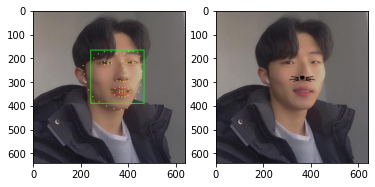

In [46]:
make_sticker_img(os.getenv('HOME')+'/aiffel/camera_sticker/images/img.png',\
                 os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png',640, 640)

68
(x,y) : (306,181)
(w,h) : (27,27)
(x,y) : (306,168)


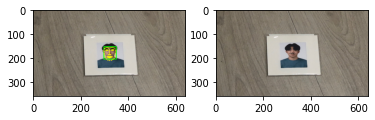

In [47]:
make_sticker_img(os.getenv('HOME')+'/aiffel/camera_sticker/images/image2.png',\
                 os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png',640,360)

68
(x,y) : (252,204)
(w,h) : (107,107)
(x,y) : (252,151)


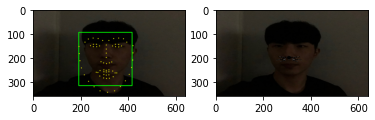

In [48]:
make_sticker_img(os.getenv('HOME')+'/aiffel/camera_sticker/images/image3.png',\
                 os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png',640,360)

## 🔍 회고

> #### - 정면 사진보다 각도가 틀어졌을때 두 볼의 위치는 잡지만 코의 위치가 안맞는 모습을 볼 수 있다.
> #### - 얼굴의 각도가 틀어지면 스티커의 각도도 틀어져야 한다.
> #### - 이미지 밝기가 엄청 어둡거나 엄청 밝을경우, Landmark가 잘못 생성될 수 있다.
> #### - 멀리서 촬영을 할 경우, Landmark의 간격이 좁아질 위험이 있다.
> #### - 옆으로 누워서 촬영할 경우, 얼굴 인식이 제대로 안될 수 있다.